In [44]:
import torch
import torch.nn.functional as F
import pandas as pd
import warnings as wrn
from typing import Optional, Tuple
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import time

wrn.filterwarnings("ignore")

model_name = "SamLowe/roberta-base-go_emotions"

config = AutoConfig.from_pretrained(model_name)
label_names = config.id2label

original_labels = [label_names[i] for i in range(len(label_names))]
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

df = pd.read_csv('../../data/test.csv')
new_labels = df.sentiment.unique().tolist()

print(original_labels)
print(new_labels)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
['Happy', 'Surprised', 'Curious to dive deeper', 'Neutral', 'Sad', 'Fearful', 'Angry', 'Disgusted']


In [45]:
len(df)

11302

In [19]:
df.head(10)

,conversation_id,message,sentiment
0,5748,"Nice. My Zeppelin only goes0.160 mph, so I do...",Happy
1,3347,That is a lot! And 60 million of them are in t...,Surprised
2,7034,well i'm not sure if it was a government or a...,Surprised
3,3318,Hi! Are you into soccer or the FIFA world cup ...,Happy
4,283,They might need him,Curious to dive deeper
5,3033,Do you listen to much music?,Curious to dive deeper
6,4227,"ya I agree, I wonder if he would be mad that ...",Curious to dive deeper
7,3679,Thanks you too!,Happy
8,3868,oh yeah! I like doing that sometimes to set th...,Curious to dive deeper
9,1825,"Hahaa, Really? That's funny....I was surprise...",Surprised


In [37]:
import torch
import torch.nn.functional as F
import pandas as pd
import os
from typing import Optional, Tuple
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import time


def load_model(model_name: Optional[str]="SamLowe/roberta-base-go_emotions") -> Tuple[AutoModelForSequenceClassification, AutoTokenizer, AutoConfig]:
    """
        Load model from Hugging Face Transformers library with pretrained
        weights and tokenizer.
    """

    config = AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    return (model, tokenizer, config)

def get_labels(config: AutoConfig, file: Path) -> Tuple[list, list, dict]:
    """
        Get original labels and new labels from the model.
    """

    label_mapping = {
                        'curiosity': 'Curious to dive deeper',
                        'joy': 'Happy',
                        'neutral': 'Neutral',
                        'surprise': 'Surprised',
                        'disgust': 'Disgusted',
                        'sadness': 'Sad',
                        'fear': 'Fearful',
                        'anger': 'Angry'
                    }

    label_names = config.id2label

    original_labels = [label_names[i] for i in range(len(label_names))]

    df = pd.read_csv(file)
    new_labels = df.sentiment.unique().tolist()

    return (original_labels, new_labels, label_mapping)

def get_model_output(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    return logits

def map_labels(logits, original_labels, label_mapping):
    probs = F.softmax(logits, dim=-1)
    probs = probs.squeeze().detach().cpu().numpy()
    new_probs = {}
    for orig_label, new_label in label_mapping.items():
        if orig_label in original_labels:
            new_probs[new_label] = probs[original_labels.index(orig_label)]
    return new_probs

def evaluate(file: Path, label_mapping: dict, original_labels: list, new_labels: list):
    """
        Evaluate the model on the test data.
    """

    df = pd.read_csv(file)

    y_true = df.sentiment.tolist()
    y_pred = []

    for idx, text in enumerate(df.message.tolist()):
        logits = get_model_output(text)
        probs = map_labels(logits, original_labels, label_mapping)
        pred = max(probs, key=probs.get)
        confidence = probs[pred]
        y_pred.append(pred)


    print(classification_report(y_true, y_pred, target_names=new_labels))

    cm = confusion_matrix(y_true, y_pred, labels=new_labels)
    print(cm)

    return

if __name__ == "__main__":
    file = Path('../../data/test.csv')
    model, tokenizer, config = load_model(model_name)

    original_labels, new_labels, label_mapping = get_labels(config, file)
    evaluate(file=file)


                        precision    recall  f1-score   support

                 Angry       0.11      0.08      0.09        52
Curious to dive deeper       0.65      0.41      0.50      4853
             Disgusted       0.09      0.07      0.08        86
               Fearful       0.17      0.35      0.23        62
                 Happy       0.33      0.25      0.28      1777
               Neutral       0.29      0.65      0.40      2482
                   Sad       0.20      0.31      0.25       152
             Surprised       0.32      0.16      0.21      1838

              accuracy                           0.39     11302
             macro avg       0.27      0.28      0.26     11302
          weighted avg       0.45      0.39      0.39     11302

[[   4    4    1    1    2   36    2    2]
 [  15 1966   22   33  410 1958   69  380]
 [   2    8    6    5    2   57    3    3]
 [   2    5    0   22    4   24    2    3]
 [   3  286    4   10  440  917   31   86]
 [   9  385   

AttributeError: 'list' object has no attribute 'unique'

In [43]:
df = pd.read_csv('../../result/roberta-predictions.csv')
len(df)

1293852

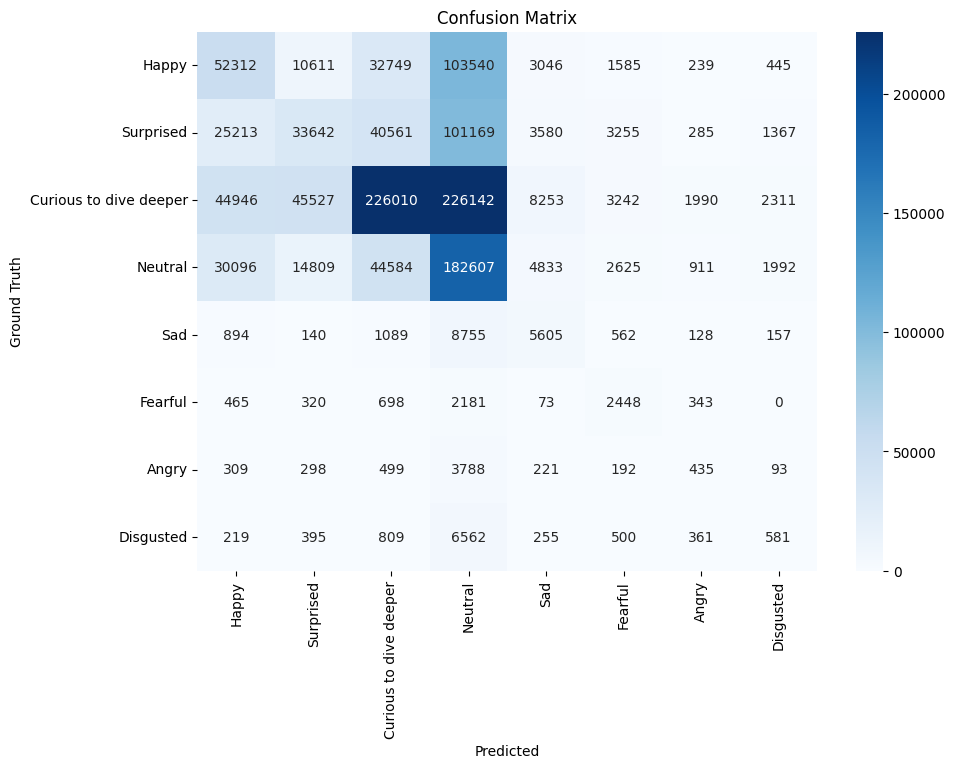

Classification Report:



KeyboardInterrupt: 

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


def load_and_evaluate(output_file='../../result/roberta-predictions.csv') -> None:
    combined_df = pd.read_csv(output_file)
    y_true = combined_df['Ground_Truth']
    y_pred = combined_df['Predicted']
    y_labels = y_true.unique().tolist()

    cm = confusion_matrix(y_true, y_pred, labels=y_labels)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=y_labels))


    report_dict = classification_report(y_true, y_pred, target_names=y_labels, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    report_df = pd.DataFrame(report_dict).transpose()

    cm_df = pd.DataFrame(cm, index=y_labels, columns=y_labels)
    
    with pd.ExcelWriter('../../result/roberta-sentiment-metrics.xlsx') as writer:
        report_df.to_excel(writer, sheet_name='Classification Report')
        cm_df.to_excel(writer, sheet_name='Confusion Matrix')

    
load_and_evaluate()

In [7]:
def get_model_output(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    return logits

def map_labels(logits, original_labels, label_mapping):
    probs = F.softmax(logits, dim=-1)
    probs = probs.squeeze().detach().cpu().numpy()
    new_probs = {}
    for orig_label, new_label in label_mapping.items():
        if orig_label in original_labels:
            new_probs[new_label] = probs[original_labels.index(orig_label)]
    return new_probs

In [9]:

text = "WHat is this?"
logits = get_model_output(text)
mapped_probs = map_labels(logits, original_labels, label_mapping)

# Get the most probable label
predicted_label = max(mapped_probs, key=mapped_probs.get)
print(f"Predicted sentiment: {predicted_label}")


Predicted sentiment: Curious to dive deeper
